**PREDICTING AIR QUALITY IN LAGOS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error

In [2]:
#The parse_dates=["date"] option ensures that the date column is recognized as a date.
df = pd.read_csv("data/lagos_air_quality.csv", parse_dates=["date"])

# Sort DataFrame by date in ascending order
df = df.sort_values(by="date", ascending=True)

In [3]:
# Display the first few rows and summary statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 665 entries, 579 to 3
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    665 non-null    datetime64[ns]
 1   pm25    665 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.6 KB


In [4]:
df.head()

,date,pm25
579,2021-01-04,98
580,2021-01-05,98
581,2021-01-06,80
582,2021-01-07,92
583,2021-01-08,65


In [5]:
df.tail()

,date,pm25
36,2023-03-31,73
0,2023-04-01,64
1,2023-04-02,53
2,2023-04-03,60
3,2023-04-04,98


**Creating New Time-Based Features**

We extract year, month, and day from the date column.

This helps the model learn seasonal trends in air quality.

In [6]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

In [7]:
df.head()

,date,pm25,year,month,day
579,2021-01-04,98,2021,1,4
580,2021-01-05,98,2021,1,5
581,2021-01-06,80,2021,1,6
582,2021-01-07,92,2021,1,7
583,2021-01-08,65,2021,1,8


**Creating Lag Features (Previous PM2.5 Values)**

This creates a new column, pm25_lag_1, which stores the previous day's PM2.5 value.

This helps the model understand how PM2.5 values change over time.

In [8]:
df["pm25_lag_1"] = df["pm25"].shift(1)

In [9]:
df.head()

,date,pm25,year,month,day,pm25_lag_1
579,2021-01-04,98,2021,1,4,NaN
580,2021-01-05,98,2021,1,5,98.0
581,2021-01-06,80,2021,1,6,98.0
582,2021-01-07,92,2021,1,7,80.0
583,2021-01-08,65,2021,1,8,92.0


**Creating Rolling Averages**

The model calculates the average PM2.5 over the last 3 days and 7 days.

Rolling averages help smooth out fluctuations in air quality readings.

In [10]:
df["pm25_rolling_3"] = df["pm25"].rolling(window=3, min_periods=1).mean()
df["pm25_rolling_7"] = df["pm25"].rolling(window=7, min_periods=1).mean()

In [11]:
df.head()

,date,pm25,year,month,day,pm25_lag_1,pm25_rolling_3,pm25_rolling_7
579,2021-01-04,98,2021,1,4,NaN,98.0,98.0
580,2021-01-05,98,2021,1,5,98.0,98.0,98.0
581,2021-01-06,80,2021,1,6,98.0,92.0,92.0
582,2021-01-07,92,2021,1,7,80.0,90.0,92.0
583,2021-01-08,65,2021,1,8,92.0,79.0,86.6


**Creating Interaction Features**

These features help the model understand how air quality changes depending on the month and day.

In [12]:
df["month_pm25"] = df["month"] * df["pm25_lag_1"]
df["day_pm25"] = df["day"] * df["pm25_lag_1"]

In [13]:
df.head()

,date,pm25,year,month,day,pm25_lag_1,pm25_rolling_3,pm25_rolling_7,month_pm25,day_pm25
579,2021-01-04,98,2021,1,4,NaN,98.0,98.0,NaN,NaN
580,2021-01-05,98,2021,1,5,98.0,98.0,98.0,98.0,490.0
581,2021-01-06,80,2021,1,6,98.0,92.0,92.0,98.0,588.0
582,2021-01-07,92,2021,1,7,80.0,90.0,92.0,80.0,560.0
583,2021-01-08,65,2021,1,8,92.0,79.0,86.6,92.0,736.0


**Handling Outliers (Capping PM2.5 at 500)**

This ensures that PM2.5 values above 500 are set to 500 because such high levels are too extreme and may be measurement error

In [14]:
df["pm25"] = df["pm25"].apply(lambda x: min(x, 500))

In [15]:
df.head()

,date,pm25,year,month,day,pm25_lag_1,pm25_rolling_3,pm25_rolling_7,month_pm25,day_pm25
579,2021-01-04,98,2021,1,4,NaN,98.0,98.0,NaN,NaN
580,2021-01-05,98,2021,1,5,98.0,98.0,98.0,98.0,490.0
581,2021-01-06,80,2021,1,6,98.0,92.0,92.0,98.0,588.0
582,2021-01-07,92,2021,1,7,80.0,90.0,92.0,80.0,560.0
583,2021-01-08,65,2021,1,8,92.0,79.0,86.6,92.0,736.0


**Creating a "High Pollution Day" Indicator**

If PM2.5 from the previous day was above 500, we mark that day as 1 (true), else 0 (false).
This feature tells the model when pollution was high in the past.

In [16]:
df["high_pollution_day"] = (df["pm25_lag_1"] > 500).astype(int)

In [17]:
df.head()

,date,pm25,year,month,day,pm25_lag_1,pm25_rolling_3,pm25_rolling_7,month_pm25,day_pm25,high_pollution_day
579,2021-01-04,98,2021,1,4,NaN,98.0,98.0,NaN,NaN,0
580,2021-01-05,98,2021,1,5,98.0,98.0,98.0,98.0,490.0,0
581,2021-01-06,80,2021,1,6,98.0,92.0,92.0,98.0,588.0,0
582,2021-01-07,92,2021,1,7,80.0,90.0,92.0,80.0,560.0,0
583,2021-01-08,65,2021,1,8,92.0,79.0,86.6,92.0,736.0,0


**Dropping Missing Values**

Since lag features create empty rows at the beginning, we remove those rows.

In [18]:
df.dropna(inplace=True)

In [19]:
df.head()

,date,pm25,year,month,day,pm25_lag_1,pm25_rolling_3,pm25_rolling_7,month_pm25,day_pm25,high_pollution_day
580,2021-01-05,98,2021,1,5,98.0,98.000000,98.000000,98.0,490.0,0
581,2021-01-06,80,2021,1,6,98.0,92.000000,92.000000,98.0,588.0,0
582,2021-01-07,92,2021,1,7,80.0,90.000000,92.000000,80.0,560.0,0
583,2021-01-08,65,2021,1,8,92.0,79.000000,86.600000,92.0,736.0,0
584,2021-01-09,70,2021,1,9,65.0,75.666667,83.833333,65.0,585.0,0


**Selecting Features for the Model**

X contains the predictor variables used for making predictions.

y contains the actual PM2.5 values (what we are trying to predict).

In [20]:
features = ["pm25_lag_1", "pm25_rolling_3", "pm25_rolling_7", "month", "day", "year", 
            "month_pm25", "day_pm25", "high_pollution_day"]
X = df[features]
y = df["pm25"]

In [21]:
X.head()

,pm25_lag_1,pm25_rolling_3,pm25_rolling_7,month,day,year,month_pm25,day_pm25,high_pollution_day
580,98.0,98.000000,98.000000,1,5,2021,98.0,490.0,0
581,98.0,92.000000,92.000000,1,6,2021,98.0,588.0,0
582,80.0,90.000000,92.000000,1,7,2021,80.0,560.0,0
583,92.0,79.000000,86.600000,1,8,2021,92.0,736.0,0
584,65.0,75.666667,83.833333,1,9,2021,65.0,585.0,0


**Splitting Data into Training and Testing Sets**

80% of the data is used for training, and 20% for testing to evaluate model performance.

We don't shuffle the data because it's time-series data.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

**Training the Linear Regression Model**

We create and train a Linear Regression model to learn patterns in PM2.5 levels.

Then, we use this trained model to predict PM2.5 on the test data.

In [23]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

**Training the Ridge Regression Model**

We also train a Ridge Regression model, which is similar to Linear Regression but better at handling outliers

In [24]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

**Creating a Baseline Model (Previous Day's PM2.5)**

A simple baseline model assumes that tomorrow's PM2.5 will be the same as today's.

This helps compare our ML models against a simple prediction.

In [25]:
baseline_pred = X_test["pm25_lag_1"]

**Evaluating Model Performance (Mean Absolute Error - MAE)**

Mean Absolute Error (MAE) tells us how far predictions are from actual values (lower is better).

We print MAE for all models to compare performance.

In [26]:
mae_baseline = mean_absolute_error(y_test, baseline_pred)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

mae_results = {
    "Baseline Model": mae_baseline,
    "Linear Regression": mae_lr,
    "Ridge Regression": mae_ridge
}
print("Model Performance (MAE):", mae_results)

Model Performance (MAE): {'Baseline Model': 19.082706766917294, 'Linear Regression': 12.735227028342228, 'Ridge Regression': 12.735505578836005}


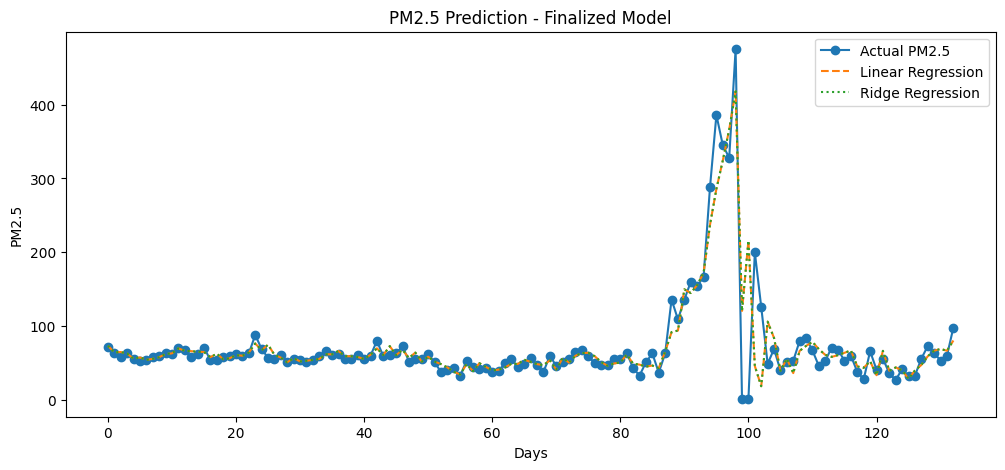

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Actual PM2.5", marker='o')
plt.plot(y_pred_lr, label="Linear Regression", linestyle="dashed")
plt.plot(y_pred_ridge, label="Ridge Regression", linestyle="dotted")
plt.xlabel("Days")
plt.ylabel("PM2.5")
plt.title("PM2.5 Prediction - Finalized Model")
plt.legend()
plt.show()

**Predicting Future PM2.5 Levels**

We predict the next 10 days of PM2.5 using both models and print the results

In [28]:
# Define the correct start date for future predictions
future_dates = pd.date_range(start="2023-04-05", periods=10, freq="D")

In [29]:
# Copy the last 10 rows from X_test for future predictions
future_data = X_test.iloc[-10:].copy()
future_data.index = future_dates  # Assign future dates as the index

In [30]:
# Predict PM2.5 for the next 10 days
future_pm25_lr = lr_model.predict(future_data)
future_pm25_ridge = ridge_model.predict(future_data)

In [31]:
# Print estimated PM2.5 levels
print("Estimated future PM2.5 levels (Linear Regression):")
print(pd.DataFrame({"Date": future_dates, "Predicted_PM2.5": future_pm25_lr}))

print("\nEstimated future PM2.5 levels (Ridge Regression):")
print(pd.DataFrame({"Date": future_dates, "Predicted_PM2.5": future_pm25_ridge}))

Estimated future PM2.5 levels (Linear Regression):
        Date  Predicted_PM2.5
0 2023-04-05        44.065977
1 2023-04-06        40.186593
2 2023-04-07        28.697433
3 2023-04-08        39.918600
4 2023-04-09        47.378861
5 2023-04-10        59.188934
6 2023-04-11        66.705097
7 2023-04-12        69.052929
8 2023-04-13        66.683707
9 2023-04-14        80.504528

Estimated future PM2.5 levels (Ridge Regression):
        Date  Predicted_PM2.5
0 2023-04-05        44.076921
1 2023-04-06        40.197454
2 2023-04-07        28.709110
3 2023-04-08        39.929505
4 2023-04-09        47.389638
5 2023-04-10        59.200041
6 2023-04-11        66.716976
7 2023-04-12        69.064618
8 2023-04-13        66.695269
9 2023-04-14        80.516153
